In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import geopandas
from shapely import geometry
import matplotlib.cm as color_map
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV

from scipy.spatial import distance_matrix

import folium

#plt.rcParams['figure.figsize']=(12,12)
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")


## Load data and clean data

Data is gathered from the website: http://www.airbezen.be/ and saved in a json. Here you see the measurements on a map:

<img src="http://www.airbezen.be/page-7/files/stacks-image-f1fbc0f.jpg" style="max-height:400px;"><br>

From each measurement, we extract the following information:

- longitude
- latitude
- post_code
- quality: the measured air quality
- info: extra info

We convert lat/lon coordinates to Lambert coordinates, to have units on a square grid in meters.

On the legend of the map on the website, we see that some measurements are colored grey. The legend says *'Dichtbij sporen, mogelijk verhoogd'*. This is reflected by the info in the json, where for some measurement it says: *'Plantje dicht bij sporen (trein of tram): de meetwaarde is mogelijk verhoogd door spoorverkeer.'* As the authors are clearly doubting these values (otherwhise they would not color them gray, we drop these measurements.



In [101]:
# Read in the json file
with open('raw_data/airquality.json',encoding='latin1') as airquality_json:
    d = json.load(airquality_json)
## take the important columns 
longitude= [i['longitude'] for i in d if 'longitude' in i]
latitude=[i['latitude'] for i in d if 'latitude' in i]
quality=[i['data'][:][5] for i in d if 'data' in i]
info=[i['data'][:][6] for i in d if 'data' in i]

post_code=[i['data'][:][4] for i in d if 'data' in i]

air_df=pd.DataFrame({'longitude':longitude,'latitude':latitude, 'quality':quality, 'post_code':post_code, 'info':info})
air_df['test'] = air_df.quality.str.extract('([0-9]*)', expand=True)
air_df['quality'] = pd.to_numeric(air_df['test'])

## get x  and y coordinates from lat and lon
points = air_df.apply(lambda x: geometry.Point(x.longitude, x.latitude), axis=1)

air_df_sp = geopandas.GeoDataFrame(air_df, crs={'init':'epsg:4326'}, geometry=points)
air_df_sp = air_df_sp.to_crs(epsg=31370)

air_df['x']=air_df_sp['geometry'].x.values
air_df['y']=air_df_sp['geometry'].y.values
air_df['x_km']=air_df['x']/1000
air_df['y_km']=air_df['y']/1000

## remove missings 
air_df = air_df[~air_df['quality'].isnull()].copy() ## 2 missing values 

# Work with scaled logarithm
air_df['log_quality'] = np.log(air_df['quality']+1)
air_df['log_quality'] = air_df['log_quality'] - air_df['log_quality'].mean()
air_df.head()

,info,latitude,longitude,post_code,quality,test,geometry,x,y,x_km,y_km,log_quality
0,De meetwaarde van dit plantje behoort tot de 2...,51.250270,3.418186,AIRbezen code 9992_0001,18.0,18,POINT (3.418186 51.25027),83631.735189,216020.079074,83.631735,216.020079,-1.136252
1,De meetwaarde van dit plantje behoort tot de 2...,51.199017,3.504034,AIRbezen code 9991_0008,17.0,17,POINT (3.504034 51.1990166),89558.944342,210245.064480,89.558944,210.245064,-1.190319
2,De meetwaarde van dit plantje behoort tot de 2...,51.208670,3.450600,AIRbezen code 9990_CAMPUS COURTMANSLAAN,27.0,27,POINT (3.4506 51.20867),85837.554782,211363.765268,85.837555,211.363765,-0.748486
3,De meetwaarde van dit plantje behoort tot de 2...,51.213608,3.395916,AIRbezen code 9990_0124,13.0,13,POINT (3.395916 51.2136078),82023.546726,211961.694158,82.023547,211.961694,-1.441633
4,De meetwaarde van dit plantje behoort tot de 2...,51.239822,3.441225,AIRbezen code 9990_0121,21.0,21,POINT (3.441225 51.2398224),85225.708268,214837.486043,85.225708,214.837486,-0.989648


In [102]:
# Drop the measurements that were close to a railway, and colored gray by the original author
air_df = air_df.loc[(air_df['info'] != 'Plantje dicht bij sporen (trein of tram): de meetwaarde is mogelijk verhoogd door spoorverkeer.'),:]
air_df['info'].value_counts()

De meetwaarde van dit plantje behoort tot de 20% laagste waarden gemeten in de provincie.           564
De meetwaarde van dit plantje behoort tot de 20 tot 40% laagste waarden gemeten in de provincie.    555
De meetwaarde van dit plantje schommelt rond de mediaan van de provincie.                           555
De meetwaarde van dit plantje behoort tot de 20 tot 40% hoogste waarden gemeten in de provincie.    538
De meetwaarde van dit plantje behoort tot de 20% hoogste waarden gemeten in de provincie.           516
Name: info, dtype: int64

## Plot of raw data

We make a histogram plot of the raw data. With this histogram, we conclude to drop some outliers that have air quality measures above 600.

We also transform the measurements into the logarithms, as the distribution of the measurements is quite skewed. 

We also make a map, to confirm we see the same data as we do see on the airbezen website.

In [103]:
#after visualy inspecting, we remove values that are about 600
print('Number of observations without cutting outliers: {}'.format(len(air_df)))
air_df = air_df.loc[air_df['quality'] < 600, :]
print('Number of observations after cutting outliers: {}'.format(len(air_df)))

Number of observations without cutting outliers: 2728
Number of observations after cutting outliers: 2720


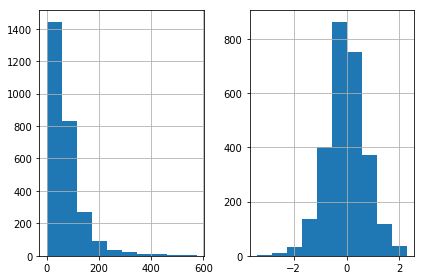

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2)

air_df['quality'].hist(ax=axes[0])
air_df['log_quality'].hist(ax=axes[1])

fig.tight_layout()


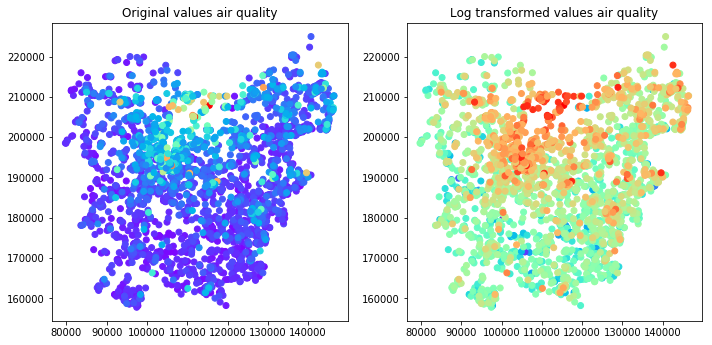

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
axes[0].scatter(air_df['x'], air_df['y'], c=air_df['quality'], cmap=color_map.rainbow)
axes[0].set_aspect(aspect='equal')
axes[0].set_title('Original values air quality')

axes[1].scatter(air_df['x'], air_df['y'], c=air_df['log_quality'], cmap=color_map.rainbow)
axes[1].set_aspect(aspect='equal')
axes[1].set_title('Log transformed values air quality')
fig.tight_layout()


## Do we see spatial correlation?

Does the squared difference between the measurements decreases if they are close to eachother? 

In [106]:
air_df = air_df.sample(frac=1)

In [107]:
# Takes quite a while...
distances_measurements = distance_matrix(air_df[['x_km', 'y_km']], air_df[['x_km', 'y_km']])

variogram_data = []

#for i, row_i in enumerate(distances_measurements):
#    if(i%100==0): print(i)
#    if(i>300):break
#    for j, distance in enumerate(distances_measurements[i]):
#        if(distance<0.01): continue
#        if(distance>15): continue
#        diff_squared = np.power(air_df.iloc[i, :]['log_quality'] - air_df.iloc[j, :]['log_quality'],2)
#        temp_dict = {'i': i, 'j':j, 'diff': diff_squared, 'distance': distance}
#        variogram_data.append(temp_dict)

0
100
200
300


(0, 5)

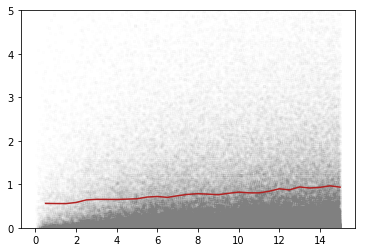

In [109]:
variogram_data = pd.DataFrame(variogram_data)
variogram_data['distance_rounded'] = np.round(variogram_data['distance']*2)/2
difference_binned = variogram_data.groupby('distance_rounded')['diff'].mean()
difference_binned = difference_binned.iloc[1:]
fig, ax = plt.subplots(1,1)
ax.plot(variogram_data['distance'], variogram_data['diff'], '.', alpha=0.005, color='grey')
ax.plot(difference_binned.index, difference_binned, color='firebrick', )
ax.set_ylim(0,5)

## Grid point sampler 

This is a helper function to sample gridpoints out of a polygon.

We use it to sample a grid out of the area covered by the airbezen measurements.

In [110]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step

Text(0.5,1,'Sampled grid')

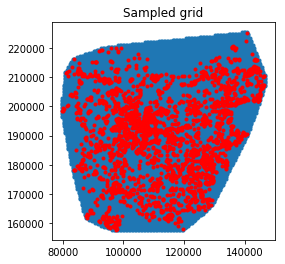

In [111]:
import shapely
convex_hull = shapely.geometry.MultiPoint(list(air_df_sp.geometry)).convex_hull.buffer(500)
sampler = RegularGridSampler(convex_hull, x_interval=500, y_interval=500)
sampler.perform_sampling()

grid_points = sampler.get_spatial_df()
plt.figure(figsize=(4,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(air_df['x'], air_df['y'], 'r.')
plt.title('Sampled grid')

## Create a holdout test set

Gaussian processes is prone to overfitting, and so we protect us against overfitting to create a leave out dataset.

In [112]:
air_df_test = air_df.sample(frac=0.1).copy()
print('Number of rows in test dataset: {}'.format(len(air_df_test)))
air_df_train = air_df.loc[~air_df.index.isin(air_df_test.index),:].copy()
print('Number of rows in train dataset: {}'.format(len(air_df_train)))


Number of rows in test dataset: 272
Number of rows in train dataset: 2448


## Baseline estimator: mean of log value

The first predictor we make a is a really simple one, being the average of the measurements (hence the name baseline, if our more sophisticated models do not outperform this baseline estimator, there is something wrong).

In [113]:
air_df_train['mean_log_quality'] = air_df['log_quality'].mean()

mse_baseline = mean_squared_error(y_true = air_df_train['log_quality'], 
                   y_pred = air_df_train['mean_log_quality'])

print('model with just the mean: MSE={:.3f}'.format(mse_baseline))

model with just the mean: MSE=0.541


## Understanding the kernel parameters

We are going to build a model with Gaussian processes, which uses a kernel. We choose to use the squared exponential kernel. This is the formula that gives the correlation:

$$k_{\textrm{SE}}(x, x') = \sigma^2\exp\left(-\frac{(x - x')^2}{2\ell^2}\right)$$

This formula basically gives the modelled correlation between two measurements separated by a distance d. This correlation is:
- zero if the distance between the meausurments is very large
- $\sigma$ if the distance is zero.

The most important parameter is the bandwith $\ell$. ($\sigma$ is just a scaling factor). This is the parameter we will tune in order to get the best map. By visually inspecting the exploratory airbezen map, we make the assumption that measurements more than 5 kilometer from each other are not correlated. So that gives us an upperbound for $\ell$, all of the kernels should never have a correlation bigger than 0 if the distance between the measurements is larger than 5000m

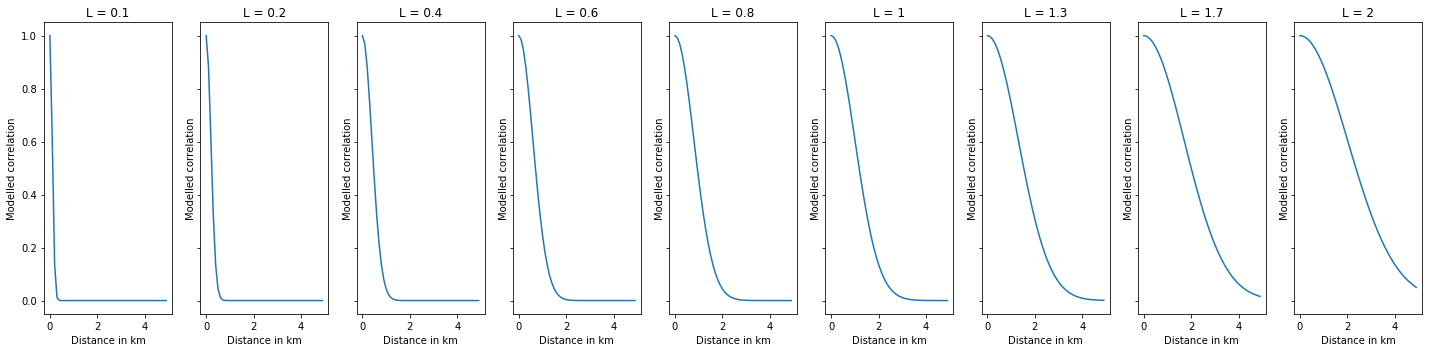

In [114]:
distances = np.arange(0, 5, step=0.1)

tuning_l = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.3, 1.7, 2]

fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 5), sharey=True)
row_index = 0
for i, l in enumerate(tuning_l):
    kernel_values = []
    for distance in distances:
        kernal_value = np.exp(-(distance**2) / (2*l**2))
        kernel_values.append(kernal_value)
    axes[i].plot(distances, kernel_values)
    axes[i].set_title('L = {}'.format(l))
    axes[i].set_xlabel('Distance in km')
    axes[i].set_ylabel('Modelled correlation')    
fig.tight_layout()  

## Gaussian Process Regressor

We implement Gaussian Process Regressor with the sklearn package. As discussed, we will need to tune the parameter $\ell$ of our squared exponential kernel. Take a look on the sklearn website for more information: http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

The formula for Radial Basis Kernel is somewhat different that the one for squared exponential (although equivalent), which means we have somewhat different tuning parameters. 

Note that we work with units in km, instead of the Lambert coordinates in meters.

In [115]:
#air_df_sampled.head()

In [116]:
param_grid = {'alpha': [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.2, 0.4, 0.8, 1.6, 3.2], 
             'kernel':[RBF(length_scale=0.5, length_scale_bounds=(0.5, 0.5)), 
                         RBF(length_scale=1, length_scale_bounds=(1, 1)), 
                       RBF(length_scale=2, length_scale_bounds=(2, 2))]}

gpr = GaussianProcessRegressor(optimizer=None)

gpr_gs = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, verbose=1, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True,n_jobs=-1)

gpr_gs.fit(X=air_df_train[['x_km','y_km']], y=air_df_train['log_quality'])




Fitting 3 folds for each of 33 candidates, totalling 99 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   14.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.2, 0.4, 0.8, 1.6, 3.2], 'kernel': [RBF(length_scale=0.5), RBF(length_scale=1), RBF(length_scale=2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

{'alpha': 1.6, 'kernel': RBF(length_scale=2)}


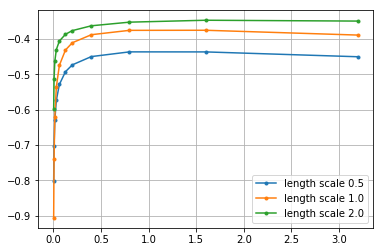

In [117]:
cv_results = pd.DataFrame(gpr_gs.cv_results_)
cv_results['param_length_scale'] = cv_results['param_kernel'].apply(lambda x: x.length_scale_bounds[1])

figure, ax = plt.subplots(ncols=1, nrows=1)
for length_scale in np.unique(cv_results['param_length_scale'].values):
    to_plot = cv_results.loc[cv_results['param_length_scale']==length_scale,['mean_test_score', 'param_alpha']]
    to_plot = to_plot.sort_values('param_alpha')
    ax.plot(to_plot['param_alpha'], to_plot['mean_test_score'],'.-', label='length scale {}'.format(length_scale))

    
ax.legend()
ax.grid()
print(gpr_gs.best_params_)

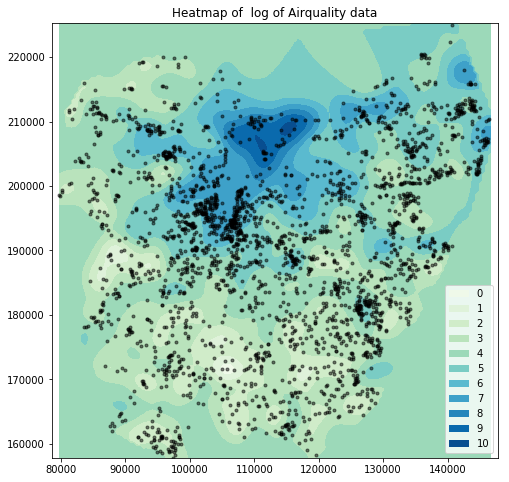

In [118]:
grid_points['gpr_prediction'], grid_points['gpr_std'] = gpr_gs.best_estimator_.predict(grid_points[['x', 'y']]/1000,return_std=True)

temp_df = pd.DataFrame({'x' : grid_points['x'].values, 'y' : grid_points['y'].values, 'z' : 
                        grid_points['gpr_prediction'],'std':grid_points['gpr_std']})
temp_df = temp_df.pivot(index = 'y', columns = 'x', values = 'z').fillna(0)

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
contourplot = ax.contourf(np.unique(grid_points['x']), np.unique(grid_points['y']), temp_df.values, 10,cmap='GnBu')

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in contourplot.collections]

plt.legend(proxy, [str(i) for i in range(len(proxy))])

ax.set_title('Heatmap of  log of Airquality data')
ax.plot(air_df['x'], air_df['y'], '.', color='black', alpha=0.5)
ax.axes.set_aspect('equal', 'datalim')



## Folium plot sklearn Gaussian process


In [119]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:31370'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)
grid_points_gpd_latlon = grid_points_gpd.to_crs({'init': 'epsg:4326'})


In [120]:
grid_points_pred_pivot = grid_points_gpd.pivot(values='gpr_prediction', columns='x', index='y').fillna(0)
grid_points_pred_pivot = grid_points_pred_pivot.loc[:,grid_points_pred_pivot.columns.sort_values(ascending=True)]
grid_points_pred_pivot = grid_points_pred_pivot.loc[grid_points_pred_pivot.index.sort_values(ascending=True),:]

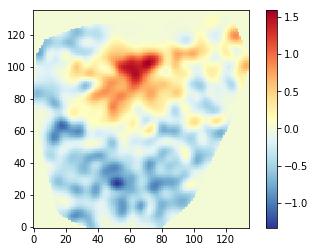

In [121]:
# Heatmap
cnorm = plt.cm.RdYlBu_r
norm=plt.Normalize(vmin=grid_points_pred_pivot.values.min(), vmax=grid_points_pred_pivot.values.max())
image = cnorm(norm(grid_points_pred_pivot.values))
plt.imshow(grid_points_pred_pivot,cmap=cnorm,origin='lower')
plt.colorbar()
# Create transparancy layer
image[:,:,3] = ~((grid_points_pred_pivot > -0.0001) & (grid_points_pred_pivot < 0.0001))

In [122]:
m = folium.Map(location=[grid_points_gpd_latlon['lat'].median(), grid_points_gpd_latlon['long'].median()],
               tiles='Stamen Toner', zoom_start=10)

folium.raster_layers.ImageOverlay(
    image=image[:,:,:4],
    bounds=[[grid_points_gpd_latlon['lat'].min(), grid_points_gpd_latlon['long'].min()], 
            [grid_points_gpd_latlon['lat'].max(), grid_points_gpd_latlon['long'].max()]],
    colormap=color_map.GnBu,
    mercator_project=True,
    opacity=0.75,
    origin='lower',
    interactive=True
).add_to(m)

m

In [123]:
## MSE 
air_df_test['sklearn_gp_log_quality'] = gpr_gs.best_estimator_.predict(air_df_test[['x_km', 'y_km']] ,return_std=False)


mse_gp = mean_squared_error(y_true = air_df_test['log_quality'], 
                   y_pred = air_df_test['sklearn_gp_log_quality'])

print('MSE Gaussian process: {:.3f}'.format(mse_gp))

MSE Gaussian process: 0.366


## Gradient boosting 

In [124]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.model_selection import cross_val_predict

In [125]:
def perform_boosting(X_train, y_train_log10, X_to_predict, verbose, quantile=None):
    
    parameters = {'n_estimators':[10,20,40,80,160,320, 640, 1280], 
                  'max_depth':[2,3]}
    if(quantile):
        gbm_regr = GradientBoostingRegressor(learning_rate=0.01, subsample=0.75, max_features=0.75, loss='quantile', alpha=quantile)
    else:
        gbm_regr = GradientBoostingRegressor(learning_rate=0.01, subsample=0.75, max_features=0.75, loss='lad')
        
    gbm_regr_gs = GridSearchCV(estimator = gbm_regr, param_grid = parameters, cv = 5, n_jobs=-1, return_train_score=True)
    gbm_regr_gs.fit(X_train, y_train_log10)
    gbm_regr_fit = gbm_regr_gs.best_estimator_
    best_score = gbm_regr_gs.best_score_
    cv_results = pd.DataFrame(gbm_regr_gs.cv_results_) 
    #penalty = (cv_results['mean_train_score'] - cv_results['mean_test_score'])/cv_results['mean_test_score']
    #penalty = (cv_results['param_n_estimators'] - cv_results['param_n_estimators'].min())/cv_results['param_n_estimators'].min()
    #cv_results['corrected_test_score'] = cv_results['mean_test_score'] - 0.1*penalty
    best_params = cv_results.sort_values('mean_test_score').tail(1)
    #gbm_regr.set_params(n_estimators = best_params['param_n_estimators'].values[0],
    #                    max_depth = best_params['param_max_depth'].values[0])
    
    #gbm_regr.fit(X_train, y_train)
    
    if(verbose):
        # CV tuning
        print('Best N trees : %s, best max depth : %s' %(str(gbm_regr_gs.best_params_['n_estimators']), str(gbm_regr_gs.best_params_['max_depth'])))
        
        fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
        cv_results['param_n_estimators_log10'] = np.log10(cv_results['param_n_estimators'].astype(float))
        cv_results['mean_test_score_log10'] = np.log10(cv_results['mean_test_score'].astype(float))
        
        for max_depth in parameters['max_depth']:
            
            axes[0,0].plot(cv_results.loc[cv_results['param_max_depth'] == max_depth,'param_n_estimators_log10'],
                        cv_results.loc[cv_results['param_max_depth'] == max_depth,'mean_test_score_log10'], '-o',
                     label = 'max_depth :%i' %max_depth)
        axes[0,0].set_title('Parameter tuning,\nmean test score {:.3f}'.format(best_params['mean_test_score'].values[0]))
        axes[0,0].set_xlabel('N trees (log10)')
        axes[0,0].set_ylabel('Rsquare (log10)')
        axes[0,0].legend(loc = 'right')
    
        # Plot of feature importances
        feature_importances = pd.DataFrame({'importances': gbm_regr_fit.feature_importances_, 
                                            'features':X_train.columns})
        feature_importances = feature_importances.sort_values('importances', ascending=False)
        axes[0,1].barh(y = np.arange(len(feature_importances))[::-1], 
                 tick_label = feature_importances['features'],
                 width = feature_importances['importances'])
        axes[0,1].set_title('Feature importances')

        counter = 0
        # Plot of feature effects
        for index, feature in enumerate(list(feature_importances['features'])):
            feature_effect = partial_dependence(gbrt=gbm_regr_fit, target_variables=[list(X_train.columns).index(feature)],X=X_train )
            if(counter < 5):
                axes[1,index].plot(feature_effect[1][0],feature_effect[0][0] )
                axes[1,index].set_title(feature)
                axes[1,index].set_ylim(-0.2, 0.2)
            if((counter >= 5) & (counter < 10)):
                axes[2,index-5].plot(feature_effect[1][0],feature_effect[0][0] )
                axes[2,index-5].set_title(feature)
                axes[2,index-5].set_ylim(-0.2, 0.2)
            counter = counter + 1
            
        plt.tight_layout()
        fig.tight_layout()
    
    # Predictions
    cv_predict_log10 = cross_val_predict(gbm_regr_fit, X_train, y_train_log10, cv=5, n_jobs = -1)
    cv_predict = 10**cv_predict_log10
    y_train = 10**y_train_log10
    z_to_predict = gbm_regr_fit.predict(X_to_predict)
    
    cv_predictions_df = pd.DataFrame({'cv_predict_log10': cv_predict_log10,
                                      'cv_predict': cv_predict, 
                                     'y_train_log10': y_train_log10,
                                     'y_train': y_train})
    cv_predictions_df['outcome_rank'] = cv_predictions_df['y_train'].rank()/len(cv_predictions_df)
    cv_predictions_df['cv_prediction_rank'] = cv_predictions_df['cv_predict'].rank()/len(cv_predictions_df)
    cv_predictions_df['abs_rel_error'] = np.abs((cv_predictions_df['y_train'] - cv_predictions_df['y_train_log10'])/cv_predictions_df['y_train'])
    
    cv_predictions_df['rel_error'] = (cv_predictions_df['cv_predict'] - cv_predictions_df['y_train'] ) / cv_predictions_df['y_train']
    cv_predictions_df['abs_rel_error'] = np.abs(cv_predictions_df['rel_error'])
    cv_predictions_df['abs_error'] = cv_predictions_df['cv_predict'] - cv_predictions_df['y_train']
    cv_predictions_df['log10_error'] = cv_predictions_df['cv_predict_log10'] - cv_predictions_df['y_train_log10']
        
    if(verbose):
        r_square = r2_score(y_true=y_train, y_pred=cv_predict)
 
        axes[0,2].plot(y_train_log10, cv_predict_log10, '.', alpha=100/len(y_train_log10))
        axes[0,2].plot([y_train_log10.min(),y_train_log10.max()], [y_train_log10.min(),y_train_log10.max()], '-', color='red')
        axes[0,2].set_title('Goodness of cv fit\nR square = {:.3f}'.format(r_square))
        axes[0,2].set_xlabel('Log prices')
        axes[0,2].set_ylabel('Log prediction')


        axes[0,3].plot(cv_predictions_df['outcome_rank'], cv_predictions_df['cv_prediction_rank'], '.', alpha=100/len(y_train_log10))
        axes[0,3].plot([0,1], [0,1], '-', color='red')
        axes[0,3].set_title('Rank rank'.format(r_square))
        axes[0,3].set_xlabel('rank prices')
        axes[0,3].set_ylabel('rankrediction')

        axes[0,4].plot(np.arange(len(cv_predictions_df)), cv_predictions_df['abs_rel_error'].sort_values(), '.')
        #
        #axes[2].plot([0,1], [0,1], '-', color='red')
        axes[0,4].set_title('Relative error, median: {:.2f}'.format(np.percentile(cv_predictions_df['abs_rel_error'],50)))
        axes[0,4].set_xlabel('')
        axes[0,4].set_ylabel('')

    return gbm_regr_fit, best_score, cv_predict_log10, z_to_predict


Best N trees : 1280, best max depth : 3


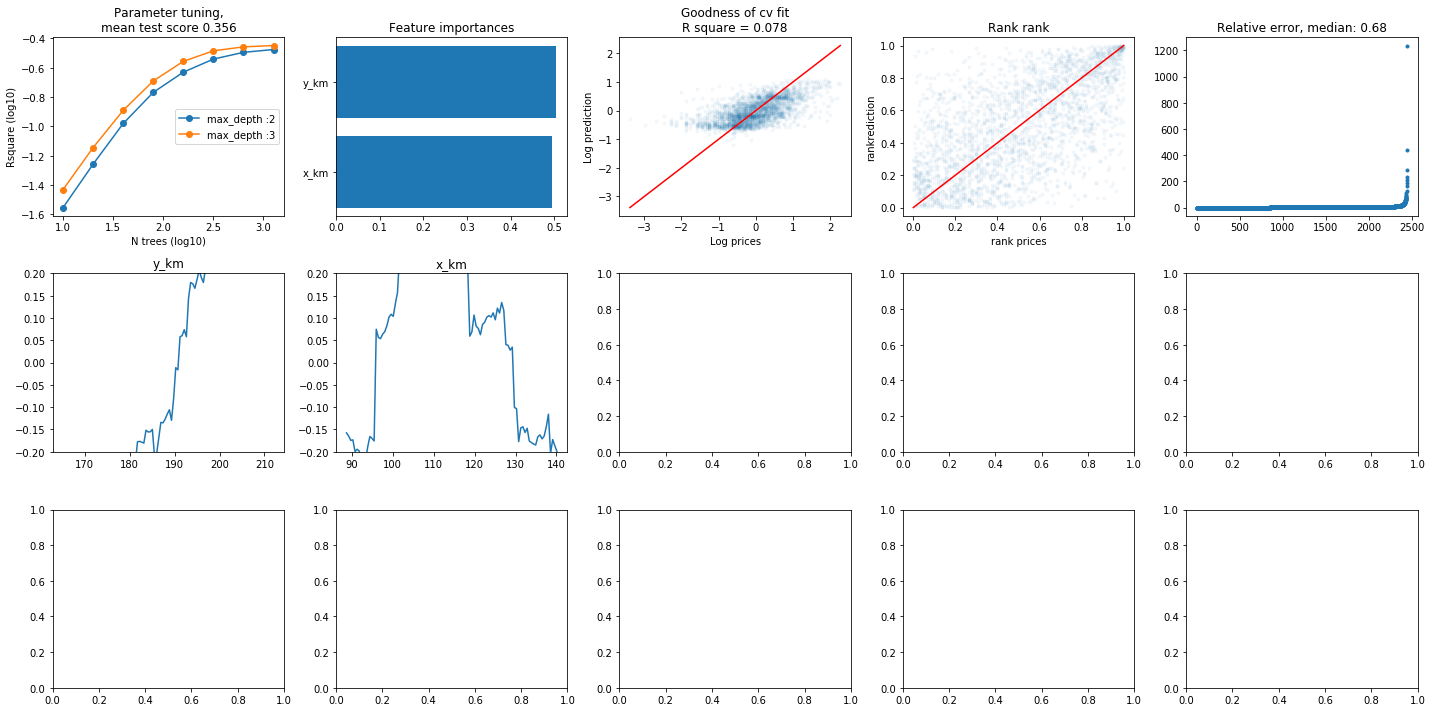

In [126]:
gbm_regr_fit, best_score, cv_predict_log10, z_to_predict = perform_boosting(air_df_train[['x_km', 'y_km']], 
                                                                            y_train_log10=air_df_train['log_quality'], 
                                                                            X_to_predict=air_df_test[['x_km', 'y_km']], 
                                                                            verbose=True)
air_df_test['sklearn_gbm_log_quality'] = z_to_predict

In [127]:
## MSE 
mse_gbm = mean_squared_error(y_true = air_df_test['log_quality'], 
                   y_pred = air_df_test['sklearn_gbm_log_quality'])

print('MSE Gaussian process: {:.3f}'.format(mse_gbm))

MSE Gaussian process: 0.370


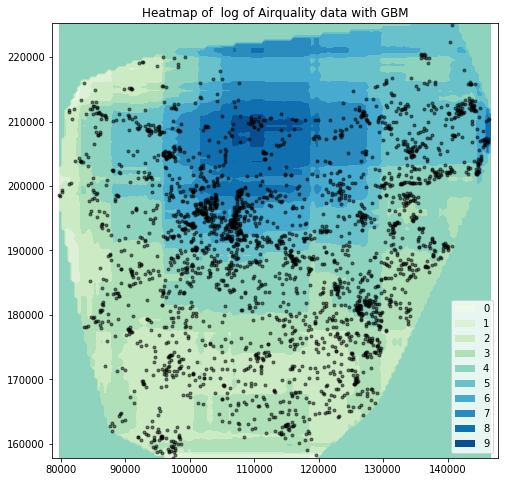

In [128]:
grid_points['gbm_prediction']= gbm_regr_fit.predict(grid_points[['x', 'y']]/1000)

temp_df = pd.DataFrame({'x' : grid_points['x'].values, 'y' : grid_points['y'].values, 'z' : 
                        grid_points['gbm_prediction']})
temp_df = temp_df.pivot(index = 'y', columns = 'x', values = 'z').fillna(0)

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
contourplot = ax.contourf(np.unique(grid_points['x']), np.unique(grid_points['y']), temp_df.values, 10,cmap='GnBu')

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in contourplot.collections]

plt.legend(proxy, [str(i) for i in range(len(proxy))])

ax.set_title('Heatmap of  log of Airquality data with GBM')
ax.plot(air_df['x'], air_df['y'], '.', color='black', alpha=0.5)
ax.axes.set_aspect('equal', 'datalim')



## The end

In [3]:
data = pd.read_csv('WeightDiary.csv')
data = data.iloc[2:,:]


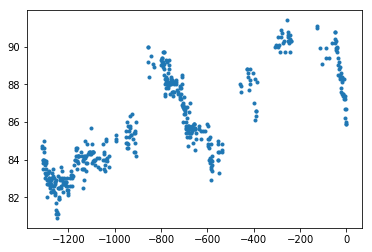

In [4]:
data['date'] = pd.to_datetime(data['units'])

basedate = pd.Timestamp('2018-03-14')
data['date_num'] = data.apply(lambda x: (x['date'] - basedate).days, axis=1)
data['kg_norm'] = data['kg'] - data['kg'].mean()
plt.plot(data['date_num'], data['kg'], '.')

In [95]:
param_grid = {'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1,2], 
             'kernel':[RBF(length_scale=20, length_scale_bounds=(20, 20)),
                      RBF(length_scale=30, length_scale_bounds=(30, 30)),
                      RBF(length_scale=40, length_scale_bounds=(40, 40)),
                      RBF(length_scale=50, length_scale_bounds=(50, 50))]}

gpr = GaussianProcessRegressor(optimizer=None)

gpr_gs = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, verbose=1, 
                      scoring='neg_mean_absolute_error',
                      return_train_score=True,n_jobs=-1)

gpr_gs.fit(X=data[['date_num']], y=data['kg_norm'])



Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False, optimizer=None,
             random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1, 2], 'kernel': [RBF(length_scale=20), RBF(length_scale=30), RBF(length_scale=40), RBF(length_scale=50)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

{'alpha': 0.02, 'kernel': RBF(length_scale=50)}


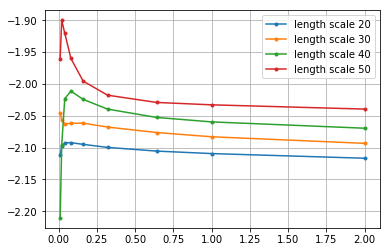

In [96]:
cv_results = pd.DataFrame(gpr_gs.cv_results_)
cv_results['param_length_scale'] = cv_results['param_kernel'].apply(lambda x: x.length_scale_bounds[1])

figure, ax = plt.subplots(ncols=1, nrows=1)
for length_scale in np.unique(cv_results['param_length_scale'].values):
    to_plot = cv_results.loc[cv_results['param_length_scale']==length_scale,['mean_test_score', 'param_alpha']]
    to_plot = to_plot.sort_values('param_alpha')
    ax.plot(to_plot['param_alpha'], to_plot['mean_test_score'],'.-', label='length scale {}'.format(length_scale))

ax.legend()
ax.grid()
print(gpr_gs.best_params_)

In [97]:
to_plot = pd.DataFrame({'date': np.arange(data['date_num'].min(), data['date_num'].max())})
to_plot['prediction'], y_cov = gpr_gs.best_estimator_.predict(to_plot[['date']], return_cov=True)
to_plot['prediction'] = to_plot['prediction'] + data['kg'].mean()

Text(0.5,0,'Days since today')

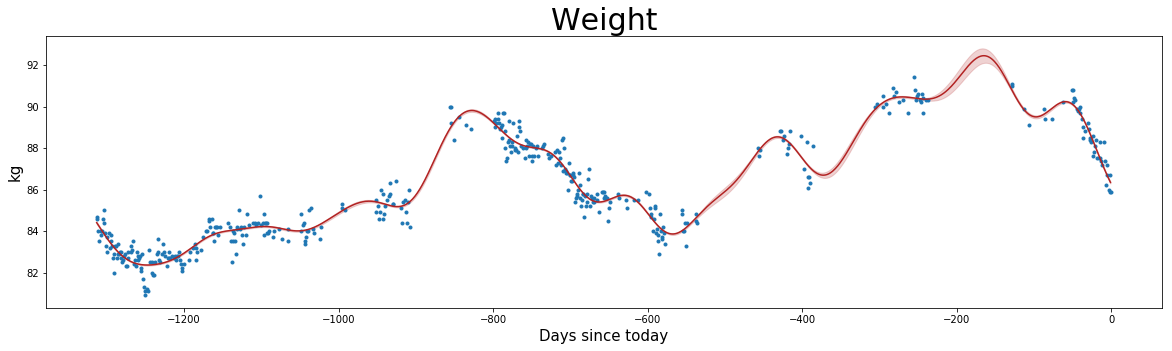

In [98]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

ax.plot(data['date_num'], data['kg'], '.')
ax.plot(to_plot['date'], to_plot['prediction'], color='firebrick')

ax.fill_between(to_plot['date'], to_plot['prediction'] - np.sqrt(np.diag(y_cov)), 
                                    to_plot['prediction'] + np.sqrt(np.diag(y_cov)),  color='firebrick', alpha=0.2)

ax.set_title('Weight', size=30)
ax.set_ylabel('kg', size=15)
ax.set_xlabel('Days since today', size=15)